##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Imports and Setup
Let's start with the base imports for running this MediaPipe sample.

In [2]:
!pip install -q mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 12.4 MB/s eta 0:00:00


## Download the interactive segmenter model

The next thing you will need to do is download the interactive segmentation model that will be used for this demo. In this case you will use the **ptm_512_hdt_ptm_woid** model.

In [3]:
#@title Start downloading here.
!wget -O model.tflite -q https://storage.googleapis.com/mediapipe-models/interactive_segmenter/magic_touch/float32/1/magic_touch.tflite

## Visualization utilities

To better demonstrate the Interactive Segmenter API, we have created a set of visualization tools that will be used in this colab. These will draw an overlay for the selected item.

In [4]:
def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int):
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px

## Download a test image

To demonstrate interactive segmentation, you can download a sample image using the following code.

It's worth noting that while this is working with a single image, you can download a collection of images to store in the `IMAGE_FILENAMES` array.

In [5]:
import urllib
IMAGE_FILENAMES = ['cats_and_dogs.jpg']

for name in IMAGE_FILENAMES:
  url = f'https://storage.googleapis.com/mediapipe-assets/{name}'
  urllib.request.urlretrieve(url, name)

## Preview the downloaded image

You can also display the test image before using it with the interactive segmenter.

cats_and_dogs.jpg


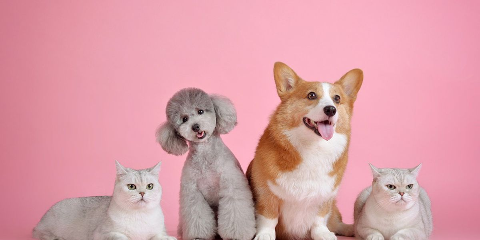

In [6]:
import cv2
from google.colab.patches import cv2_imshow
import math

# Height and width that will be used by the model
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480

# Performs resizing and showing the image
def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)


# Preview the image(s)
images = {name: cv2.imread(name) for name in IMAGE_FILENAMES}
for name, image in images.items():
  print(name)
  resize_and_show(image)

## Running inference and visualizing the results
To run inference using the interactive segmentation MediaPipe Task, you will need to initialize the `InteractiveSegmenter` using the model. This example will separate the background and foreground of the image and apply separate colors for them to highlight where each distinctive area exists. The interactive segmenter here will use a category mask, which applies a category to each found item based on confidence. You also provide a `RegionOfInterest`
argument to the `segment` method.

In [7]:
x = 0.68 #@param {type:"slider", min:0, max:1, step:0.01}
y = 0.68 #@param {type:"slider", min:0, max:1, step:0.01}

Segmentation mask of cats_and_dogs.jpg:


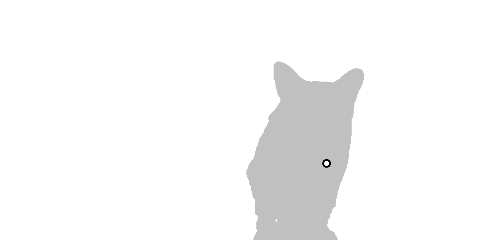

In [8]:
import numpy as np
import mediapipe as mp

from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.tasks.python.components import containers


BG_COLOR = (192, 192, 192) # gray
MASK_COLOR = (255, 255, 255) # white

RegionOfInterest = vision.InteractiveSegmenterRegionOfInterest
NormalizedKeypoint = containers.keypoint.NormalizedKeypoint

# Create the options that will be used for InteractiveSegmenter
base_options = python.BaseOptions(model_asset_path='model.tflite')
options = vision.ImageSegmenterOptions(base_options=base_options,
                                       output_category_mask=True)

# Create the interactive segmenter
with vision.InteractiveSegmenter.create_from_options(options) as segmenter:

  # Loop through demo image(s)
  for image_file_name in IMAGE_FILENAMES:

    # Create the MediaPipe image file that will be segmented
    image = mp.Image.create_from_file(image_file_name)

    # Retrieve the masks for the segmented image
    roi = RegionOfInterest(format=RegionOfInterest.Format.KEYPOINT,
                           keypoint=NormalizedKeypoint(x, y))
    segmentation_result = segmenter.segment(image, roi)
    category_mask = segmentation_result.category_mask

    # Generate solid color images for showing the output segmentation mask.
    image_data = image.numpy_view()
    fg_image = np.zeros(image_data.shape, dtype=np.uint8)
    fg_image[:] = MASK_COLOR
    bg_image = np.zeros(image_data.shape, dtype=np.uint8)
    bg_image[:] = BG_COLOR

    condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) > 0.1
    output_image = np.where(condition, fg_image, bg_image)

    # Draw a white dot with black border to denote the point of interest
    thickness, radius = 6, -1
    keypoint_px = _normalized_to_pixel_coordinates(x, y, image.width, image.height)
    cv2.circle(output_image, keypoint_px, thickness + 5, (0, 0, 0), radius)
    cv2.circle(output_image, keypoint_px, thickness, (255, 255, 255), radius)

    print(f'Segmentation mask of {image_file_name}:')
    resize_and_show(output_image)

Now that you know how to separate the foreground and background of an image, you can take it a step further and blur the background for an effect similar to what is provided by Google Hangouts.

Blurred background of cats_and_dogs.jpg:


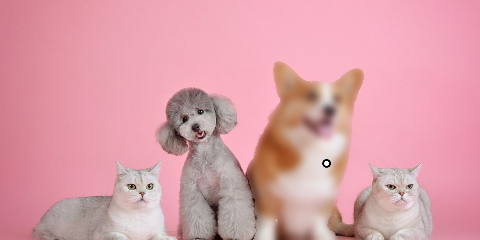

In [9]:
# Blur the image background based on the segmentation mask.

# Create the segmenter
with python.vision.InteractiveSegmenter.create_from_options(options) as segmenter:

  # Loop through available image(s)
  for image_file_name in IMAGE_FILENAMES:

    # Create the MediaPipe Image
    image = mp.Image.create_from_file(image_file_name)

    # Retrieve the category masks for the image
    roi = RegionOfInterest(format=RegionOfInterest.Format.KEYPOINT,
                           keypoint=NormalizedKeypoint(x, y))
    segmentation_result = segmenter.segment(image, roi)
    category_mask = segmentation_result.category_mask

    # Convert the BGR image to RGB
    image_data = cv2.cvtColor(image.numpy_view(), cv2.COLOR_BGR2RGB)

    # Apply effects
    blurred_image = cv2.GaussianBlur(image_data, (55,55), 0)
    condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) > 0.1
    output_image = np.where(condition, image_data, blurred_image)

    # Draw a white dot with black border to denote the point of interest
    thickness, radius = 6, -1
    keypoint_px = _normalized_to_pixel_coordinates(x, y, image.width, image.height)
    cv2.circle(output_image, keypoint_px, thickness + 5, (0, 0, 0), radius)
    cv2.circle(output_image, keypoint_px, thickness, (255, 255, 255), radius)

    print(f'Blurred background of {image_file_name}:')
    resize_and_show(output_image)

Let us generate another visualization image where we highlight the selected object with an overlay color (rather than a background blur).

cats_and_dogs.jpg:


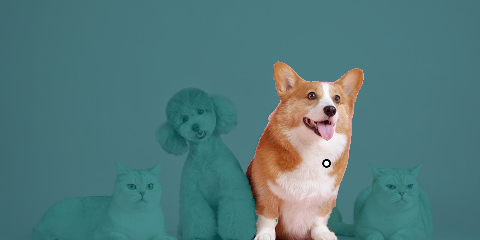

In [10]:
OVERLAY_COLOR = (100, 100, 0) # cyan

# Create the segmenter
with python.vision.InteractiveSegmenter.create_from_options(options) as segmenter:

  # Loop through available image(s)
  for image_file_name in IMAGE_FILENAMES:

    # Create the MediaPipe Image
    image = mp.Image.create_from_file(image_file_name)

    # Retrieve the category masks for the image
    roi = RegionOfInterest(format=RegionOfInterest.Format.KEYPOINT,
                           keypoint=NormalizedKeypoint(x, y))
    segmentation_result = segmenter.segment(image, roi)
    category_mask = segmentation_result.category_mask

    # Convert the BGR image to RGB
    image_data = cv2.cvtColor(image.numpy_view(), cv2.COLOR_BGR2RGB)

    # Create an overlay image with the desired color (e.g., (255, 0, 0) for red)
    overlay_image = np.zeros(image_data.shape, dtype=np.uint8)
    overlay_image[:] = OVERLAY_COLOR

    # Create the condition from the category_masks array
    alpha = np.stack((category_mask.numpy_view(),) * 3, axis=-1) > 0.1

    # Create an alpha channel from the condition with the desired opacity (e.g., 0.7 for 70%)
    alpha = alpha.astype(float) * 0.7

    # Blend the original image and the overlay image based on the alpha channel
    output_image = image_data * (1 - alpha) + overlay_image * alpha
    output_image = output_image.astype(np.uint8)

    # Draw a white dot with black border to denote the point of interest
    thickness, radius = 6, -1
    keypoint_px = _normalized_to_pixel_coordinates(x, y, image.width, image.height)
    cv2.circle(output_image, keypoint_px, thickness + 5, (0, 0, 0), radius)
    cv2.circle(output_image, keypoint_px, thickness, (255, 255, 255), radius)

    print(f'{image_file_name}:')
    resize_and_show(output_image)